In [15]:
library(tidyverse)
library(ggpubr)

theme_set(ggthemes::theme_few() + theme(text = element_text(size = 14), strip.text = element_text(size = 16)))


In [16]:
wx <- read.csv("./datasets/pivot_bio_trials_location_weather.csv")
soils <- read.csv("./datasets/pivot_bio_trials_location_soils.csv")

In [17]:
us_state <- map_data("state")

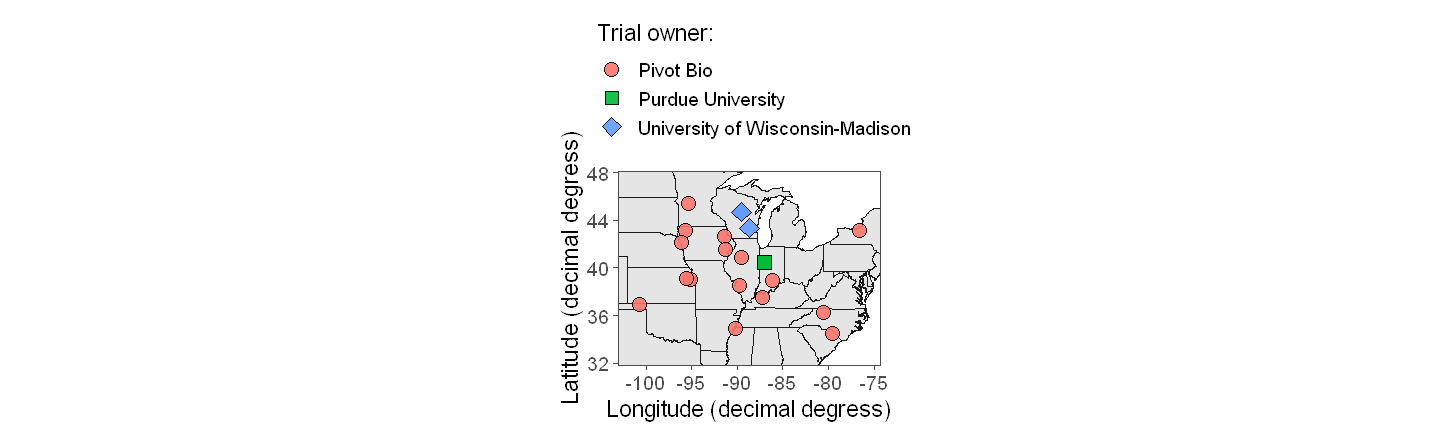

In [18]:
options(repr.plot.width=10*1.2, repr.plot.height=3*1.2)

agg_fact <- 2.5

p1 <- 
soils %>% 
ggplot(aes(long,lat)) + 
geom_polygon(data = us_state,
         aes(group = group),
             fill = "gray90", colour = "gray10") +
geom_point(aes(shape = Owner, fill = Owner), alpha = 0.9, size = 4) + 
coord_quickmap(xlim = c(min(soils$long) -1,max(soils$long) + 1),
               ylim = c(min(soils$lat) - 2,max(soils$lat) + 2)) + 
scale_shape_manual(values = c(21,22,23)) + 
scale_size_continuous(range = c(3,7)) + 
guides(fill = guide_legend(title.position = "top",nrow = 3), shape = guide_legend(title.position = "top", nrow = 3)) + 
labs(x = "Longitude (decimal degress)", y = "Latitude (decimal degress)", fill = "Trial owner:", shape = "Trial owner:") + 
theme(legend.position = "top")

p1

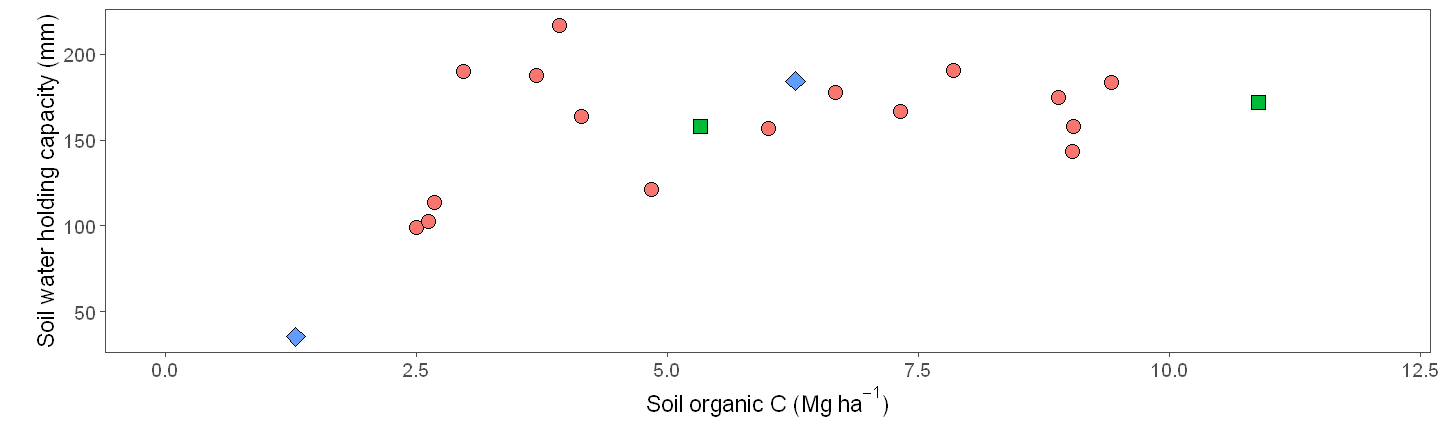

In [19]:
p2 <- 
soils %>%
ggplot(aes((soc),whc,fill = factor(Owner))) + 
geom_point(aes(shape = Owner), size = 4) + 
#geom_text(aes(label = ifelse(Owner != "Pivot Bio",gsub(" ","\n",Site_id),"")),hjust = 0.5, vjust = -0.3) + 
coord_cartesian(xlim = c(0,12)) + 
labs(
    x = expression("Soil organic C (Mg"~ha^-1*")"),
    y = "\nSoil water holding capacity (mm)",
) + 
scale_shape_manual(values = c(21,22,23)) + 
theme(legend.position = "none")
p2

In [20]:
percentile <- function(x) {ecdf(x)(x)}

p3 <- wx %>%
mutate(planting_doy = yday(as.Date(planting_date)),
tmean = (maxt + mint)/2) %>% 
filter(day %in% planting_doy:(planting_doy + 75), year %in% 1992:2022) %>% 
filter(!(grepl("PB",Site_id) & day > (planting_doy + 50))) %>% 
group_by(Site_id,trial_year,year) %>% 
summarise_at(vars(tmean,rain),sum) %>%
group_by(Site_id,trial_year) %>% 
mutate(tmean_percentile = percentile(tmean)*100, rain_percentile = percentile(rain)*100) %>% 
filter(year == trial_year) %>% 
left_join(soils) %>% 
ggplot(aes(tmean_percentile,rain_percentile,fill = factor(Owner))) + 
geom_point(aes(shape = Owner), size = 4) + 
geom_text(aes(label = ifelse(Owner != "Pivot Bio",gsub(" "," ",Site_id),"")),hjust = 0.5, vjust = -0.7) + 
coord_cartesian(xlim = c(50,100), ylim = c(0,100)) + 
labs(
    x = "Mean Temperature (percentile)",
    y = "\nCumulative rainfall (percentile)",
) + 
scale_shape_manual(values = c(21,22,23)) + 
theme(legend.position = "none")


Warning message:
"There were 2 warnings in `filter()`.
The first warning was:
i In argument: `day %in% planting_doy:(planting_doy + 75)`.
Caused by warning in `planting_doy:(planting_doy + 75)`:
! numerical expression has 329595 elements: only the first used
i Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."
Joining with `by = join_by(Site_id)`


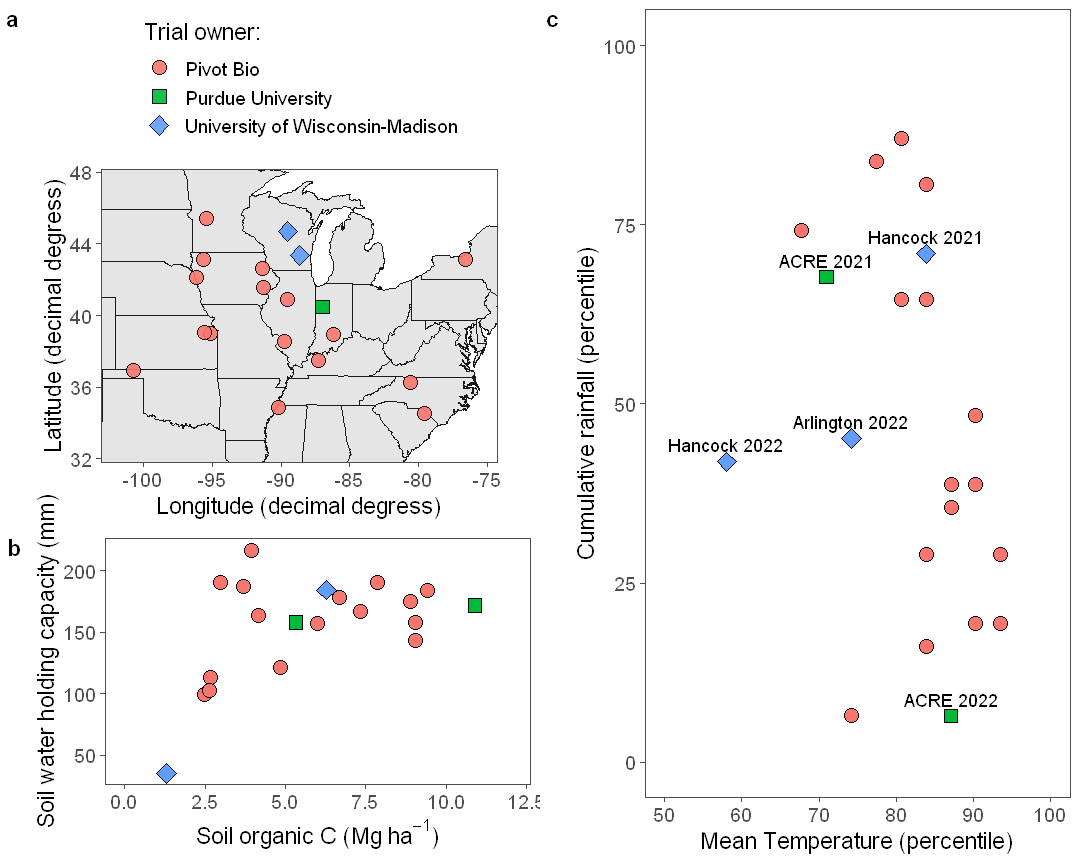

In [21]:
options(repr.plot.width=10*0.9, repr.plot.height=8*0.9)

ggarrange(
    ggarrange(p1,p2, ncol = 1, heights = c(3,1.9), labels = c("a","b")),
    p3, labels = c("","c")
)

ggsave("./figures/15N_trials.jpeg",width = 9,height = 7.2)